In [1]:
import os
from scipy import linalg as LA
from scipy.sparse.linalg import eigsh
import numpy as np
import matplotlib.pyplot as plt

from verify_deep_NFA import *

ModuleNotFoundError: No module named 'verify_deep_NFA'

In [3]:
# Path to saved neural net model
path = 'C:\Repository\DSC-180A\saved_nns\celeba_num_epochs_500_learning_rate_0.1_weight_decay_0_init_default_optimizer_sgd_freeze_False_width_1024_depth_2_act_relu_nn.pth'

In [4]:
def get_NFA_correlation(path:str, layer_idx: int=0, feature_idx: int=0):
    init, centered, uncentered = 0, 0, 0
    results = verify_NFA(
        path, 'celeba', layer_idx=layer_idx, feature_idx=feature_idx)
    i, c, u = results
    init.append(i.numpy().item())
    centered.append(c.numpy().item())
    uncentered.append(u.numpy().item())
    print("Layer " + str(layer_idx), init, centered, uncentered)
    return centered

In [6]:
def calculate_NFM_GOP(path, dataset_name, feature_idx=None, layer_idx=0):
    remove_init = False
    random_net = False

    if dataset_name == 'celeba':
        NUM_CLASSES = 2
        FEATURE_IDX = feature_idx
        SIZE = 96
        c = 3
        dim = c * SIZE * SIZE
    elif dataset_name == 'svhn' or dataset_name == 'cifar':
        NUM_CLASSES = 10
        SIZE = 32
        c = 3
        dim = c * SIZE * SIZE
    elif dataset_name == 'cifar_mnist':
        NUM_CLASSES = 10
        c = 3
        SIZE = 32
        dim = c * SIZE * SIZE * 2
    elif dataset_name == 'stl_star':
        NUM_CLASSES = 2
        c = 3
        SIZE = 96
        dim = c * SIZE * SIZE

    width, depth, act_name = read_configs(path)

    net, M = load_nn(path, width, depth, dim, NUM_CLASSES, layer_idx=layer_idx,
                     remove_init=remove_init, act_name=act_name)
    subnet = build_subnetwork(net, M.shape[0], width, depth, NUM_CLASSES, layer_idx=layer_idx,
                              random_net=random_net, act_name=act_name)
    
    if dataset_name == 'celeba':
        trainloader, valloader, testloader = dataset.get_celeba(FEATURE_IDX,
                                                                num_train=20000,
                                                                num_test=1)
    elif dataset_name == 'cifar':
        trainloader, valloader, testloader = dataset.get_cifar(num_train=1000,
                                                               num_test=1)
    elif dataset_name == 'stl_star':
        trainloader, valloader, testloader = dataset.get_stl_star(num_train=1000,
                                                                  num_test=1)
    out = get_layer_output(net, trainloader, layer_idx=layer_idx)
    G = egop(subnet, out, centering=True)
    G2 = egop(subnet, out, centering=False)

    print(f"Calulated Neural Feature Matrix and Gradient Outer Product for layer: {layer_idx}")

    return M, G

In [7]:
path = 'C:/Repository/dsc-180a-1/saved_nns/feature_29_rosycheeks/celeba_num_epochs_500_learning_rate_0.1_weight_decay_0_init_default_optimizer_sgd_freeze_False_width_1024_depth_5_act_relu_nn.pth'
M, G = calculate_NFM_GOP(
        path, 'celeba', layer_idx=0, feature_idx=29)

['C:/Repository/dsc-180a-1/saved', 'nns/feature', '29', 'rosycheeks/celeba', 'num', 'epochs', '500', 'learning', 'rate', '0.1', 'weight', 'decay', '0', 'init', 'default', 'optimizer', 'sgd', 'freeze', 'False', 'width', '1024', 'depth', '5', 'act', 'relu', 'nn.pth']
(1024, 27648)


  0%|          | 2/19962 [00:00<00:29, 666.71it/s]


Train Size:  2027 Val Size:  507 Test Size:  1
Computing Jacobian for batch:  0 3
Computing Jacobian for batch:  1 3
Computing Jacobian for batch:  2 3
torch.Size([2027, 2, 27648])
0 3
1 3
2 3
Computing Jacobian for batch:  0 3
Computing Jacobian for batch:  1 3
Computing Jacobian for batch:  2 3
torch.Size([2027, 2, 27648])
0 3
1 3
2 3


In [12]:
def plot_NFM_GOP(Mat, feature_name="Placeholder", dataset='default', save=False):
    save_path = os.path.join(os.getcwd(), 'image_outputs/NFM_GOP')
    # Extract the diagonal
    diagonal = np.diag(Mat)

    # Split the diagonal into three parts for RGB channels
    length = len(diagonal) // 3
    diagonal_r = diagonal[:length]
    diagonal_g = diagonal[length:2*length]
    diagonal_b = diagonal[2*length:]

    # Reshape each part into a 96x96 matrix
    image_r = diagonal_r.reshape(96, 96)
    image_g = diagonal_g.reshape(96, 96)
    image_b = diagonal_b.reshape(96, 96)

    # Stack the reshaped parts to form a 96x96x3 image
    image_rgb = np.stack((image_r, image_g, image_b), axis=-1)

    # Scale the values to be in the range [0, 1] for visualization
    image_rgb_scaled = (image_rgb - np.min(image_rgb)) / (np.max(image_rgb) - np.min(image_rgb))

    # Display the image
    plt.imshow(image_rgb_scaled)
    plt.title(feature_name)
    plt.axis('off')  # Turn off axis numbers
    if save:
        plt.savefig(f"{save_path}/{feature_name}_{dataset}.png",
                    bbox_inches='tight')
    plt.show()

    # matrix becomes immutable so we have to copy to make it mutable
    diagonal = np.diag(Mat).copy()  # Make a mutable copy

    # Split the diagonal into three parts for RGB channels
    length = len(diagonal) // 3
    diagonal_r = diagonal[:length].copy()  # Make a mutable copy
    diagonal_g = diagonal[length:2*length].copy()  # Make a mutable copy
    diagonal_b = diagonal[2*length:].copy()  # Make a mutable copy

    # Reshape each part into a 96x96 matrix
    image_r = diagonal_r.reshape(96, 96)
    image_g = diagonal_g.reshape(96, 96)
    image_b = diagonal_b.reshape(96, 96)

    # filter the 2% of pixels to black
    for image in [image_r, image_g, image_b]:
        threshold = np.percentile(image, 98)  # Find the 98th percentile
        # Replace pixels above the threshold with 1
        image[image > threshold] = 1

    # Stack the reshaped parts to form a 96x96x3 image
    image_rgb = np.stack((image_r, image_g, image_b), axis=-1)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis numbers
    if save:
        plt.savefig(f"{save_path}/{feature_name}_{dataset}_Thresh.png",
                    bbox_inches='tight')
    plt.show()

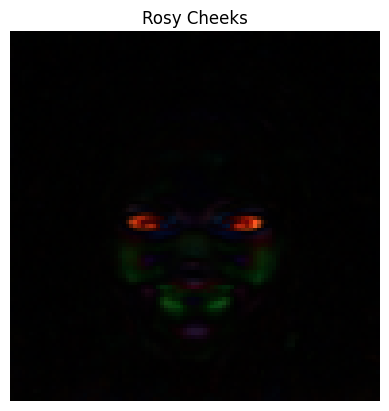

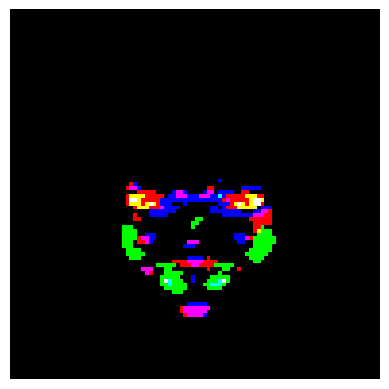

In [13]:
plot_NFM_GOP(M, feature_name='Rosy Cheeks', dataset='celeba', save=True)

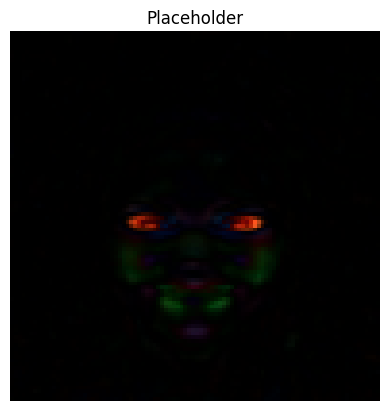

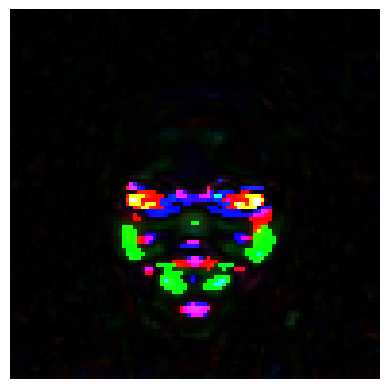

In [14]:
plot_NFM_GOP(G)

In [28]:
def plot_top_eigenvector(Mat, feature_name="TopEigenvector", dataset='placeholder', save=False):
    # Compute eigenvectors and eigenvalues of the square matrix
    eigenvalues, eigenvectors = eigsh(Mat, k=1)

    # Extract the top eigenvector
    top_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]

    # Split the top eigenvector into three parts for RGB channels
    length = len(top_eigenvector) // 3
    top_eigenvector_r = top_eigenvector[:length]
    top_eigenvector_g = top_eigenvector[length:2*length]
    top_eigenvector_b = top_eigenvector[2*length:]

    # Reshape each part into a 96x96 matrix for visualization
    image_r = top_eigenvector_r.reshape(96, 96)
    image_g = top_eigenvector_g.reshape(96, 96)
    image_b = top_eigenvector_b.reshape(96, 96)

    # Normalize each channel to be in the range [0, 1]
    image_r = (image_r - np.min(image_r)) / (np.max(image_r) - np.min(image_r))
    image_g = (image_g - np.min(image_g)) / (np.max(image_g) - np.min(image_g))
    image_b = (image_b - np.min(image_b)) / (np.max(image_b) - np.min(image_b))

    # Combine into a single RGB image
    top_image_rgb = np.stack((image_r, image_g, image_b), axis=-1)

    # Plot the top eigenvector
    plt.imshow(top_image_rgb)
    plt.title(f"{feature_name}")
    plt.axis('off')
    plt.show()

    # Save the plot if required
    if save:
        plt.savefig(f"{feature_name}_{dataset}.png", bbox_inches='tight')
        plt.close()

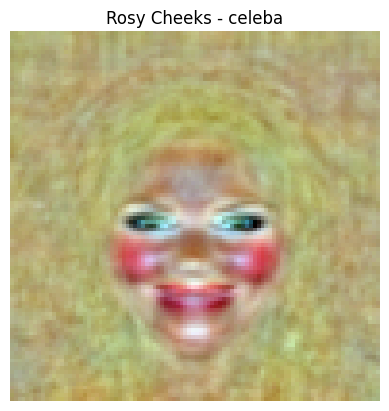

In [32]:
plot_top_eigenvector(G.cpu().numpy(), 'Rosy Cheeks', dataset='celeba', save=True)